# Timeline analysis of diabetes terms used by the users

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import numpy as np

In [2]:
src = '../data'

In [3]:
twitter = pd.read_csv(join(src, 'twitter_user_timelines.csv'), parse_dates = ['created_at'])
reddit = pd.read_csv(join(src, 'reddit_user_comments.csv'))

/home/jana/anaconda3/envs/misinfo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,3,10,12,16,17,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/jana/anaconda3/envs/misinfo/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,1,3,5,6,8,9,11,12,13,18,20,22,23,25,28,29,34,36,37,38,41,42,43,45,49,50,51,52,54,55,57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Cleaning and transforming

In [4]:
# remove bots and organisations
N = len(twitter)
twitter_bots = pd.read_csv(join(src, 'twitter_user_bot_and_org_flags.csv'))
good_users = twitter_bots[(twitter_bots['bot'] == False) &\
                          (twitter_bots['org'] == False)]['username']
print('{} non-bot and non-organisation users left'.format(len(good_users)))
twitter = twitter[twitter['author.username'].isin(good_users)]
print('{} / {} tweets left'.format(len(twitter), N))
twitter.to_csv(join(src, 'twitter_user_timelines_clean.csv'), index=False)

103 non-bot and non-organisation users left
1298626 / 3053894 tweets left


In [5]:
# transform time data
twitter['created_at'] = twitter['created_at'].dt.tz_localize(None)
reddit['created_at'] = pd.to_datetime(reddit['created_utc'], unit='s')

In [6]:
N_reddit_users = len(reddit['author'].unique())
N_reddit_posts = len(reddit)
N_twitter_users = len(twitter['author.username'].unique())
N_twitter_posts = len(twitter)

print('Reddit: {} posts from {} users'.format(N_reddit_posts, N_reddit_users))
print('Twitter: {} posts from {} users'.format(N_twitter_posts, N_twitter_users))

Reddit: 298698 posts from 175 users
Twitter: 1298626 posts from 103 users


## Align dates by diagnosis date

In [7]:
twitter_diagnosis_tweets = pd.read_csv(\
    join(src, 'twitter_user_diagnosis_dates.csv'), parse_dates=['created_at', 'created_at_date'])
twitter_diagnosis_tweets = twitter_diagnosis_tweets[\
                twitter_diagnosis_tweets['author.username'].isin(good_users)]
twitter_diagnosis_tweets = twitter_diagnosis_tweets.set_index('author.username')
# convert to naive timezone (we are only interested in days, so the few hours
# of error we can potentially make here are negligible)
twitter_diagnosis_tweets['created_at'] = twitter_diagnosis_tweets['created_at'].dt.tz_localize(None)


In [8]:
reddit_diagnosis_posts = pd.read_csv(join(src, 'reddit_user_diagnosis_dates.csv'),
                        parse_dates=['created_dt'])
reddit_diagnosis_posts = reddit_diagnosis_posts\
    .rename(columns={'created_dt':'created_at'})\
    .drop(columns=['created_utc'])
reddit_diagnosis_posts = reddit_diagnosis_posts.set_index('author')

# we only sample 175 random users from the reddit data
reddit = reddit[reddit['author'].isin(reddit_diagnosis_posts.index)]

In [9]:
def calculate_diagnosis_time_difference_twitter(row):
    username = row['author.username']
    tweet_datetime = row['created_at']
    diagnosis_datetime = twitter_diagnosis_tweets.loc[username]['created_at']
    datetime_diff =  tweet_datetime - diagnosis_datetime

    return datetime_diff

In [10]:
def calculate_diagnosis_time_difference_reddit(row):
    userID = row['author']
    post_datetime = row['created_at']
    diagnosis_datetime = reddit_diagnosis_posts.loc[userID]['created_at']
    datetime_diff =  post_datetime - diagnosis_datetime

    return datetime_diff

In [11]:
twitter['timediff_to_diagnosis'] = twitter[['author.username', 'created_at']]\
    .apply(calculate_diagnosis_time_difference_twitter, axis=1)
twitter['timediff_to_diagnosis'] = twitter['timediff_to_diagnosis'].dt.days

In [12]:
reddit['timediff_to_diagnosis'] = reddit[['author', 'created_at']]\
    .apply(calculate_diagnosis_time_difference_reddit, axis=1)
reddit['timediff_to_diagnosis'] = reddit['timediff_to_diagnosis'].dt.days

## Activity analysis

In [13]:
twitter_activity = twitter[['author.username', 'timediff_to_diagnosis', 'id']]\
    .groupby(['author.username', 'timediff_to_diagnosis'])\
    .agg('count')\
    .rename(columns={'id':'tweet_count'})\
    .reset_index()

In [14]:
twitter_activity.head()

,author.username,timediff_to_diagnosis,tweet_count
0,AMBASSADORICK,-635,1
1,AMBASSADORICK,-632,1
2,AMBASSADORICK,-489,1
3,AMBASSADORICK,-114,21
4,AMBASSADORICK,-113,14


In [15]:
reddit_activity = reddit[['author', 'timediff_to_diagnosis', 'id']]\
    .groupby(['author', 'timediff_to_diagnosis'])\
    .agg('count')\
    .rename(columns={'id':'post_count'})\
    .reset_index()

In [16]:
reddit_activity.head()

,author,timediff_to_diagnosis,post_count
0,6lackPrincess,-63,1
1,6lackPrincess,-49,1
2,6lackPrincess,-48,8
3,6lackPrincess,-46,6
4,6lackPrincess,-45,5


In [17]:
user_averaged_twitter_activity = twitter_activity[['timediff_to_diagnosis', 'tweet_count']]\
    .groupby('timediff_to_diagnosis')\
    .agg('mean')\
    .reset_index()

In [18]:
user_averaged_twitter_activity.head()

,timediff_to_diagnosis,tweet_count
0,-4080,1.0
1,-4078,1.0
2,-4069,1.0
3,-4068,1.0
4,-4067,1.0


In [19]:
user_averaged_reddit_activity = reddit_activity[['timediff_to_diagnosis', 'post_count']]\
    .groupby('timediff_to_diagnosis')\
    .agg('mean')\
    .reset_index()

In [20]:
user_averaged_reddit_activity.head()

,timediff_to_diagnosis,post_count
0,-4124,1.0
1,-3921,1.0
2,-3909,1.0
3,-3897,2.0
4,-3896,1.0


In [21]:
twitter_active_users = []
for timediff in range(-4000, 4001):
    users = twitter_activity[twitter_activity['timediff_to_diagnosis'] == timediff]
    twitter_active_users.append(len(users['author.username'].unique()))

In [22]:
reddit_active_users = []
for timediff in range(-4000, 501):
    users = reddit_activity[reddit_activity['timediff_to_diagnosis'] == timediff]
    reddit_active_users.append(len(users['author'].unique()))

In [23]:
twitter_active_users = pd.DataFrame({'active_users':twitter_active_users, 
                             'timediff_to_diagnosis':range(-4000, 4001)})

reddit_active_users = pd.DataFrame({'active_users':reddit_active_users, 
                             'timediff_to_diagnosis':range(-4000, 501)})

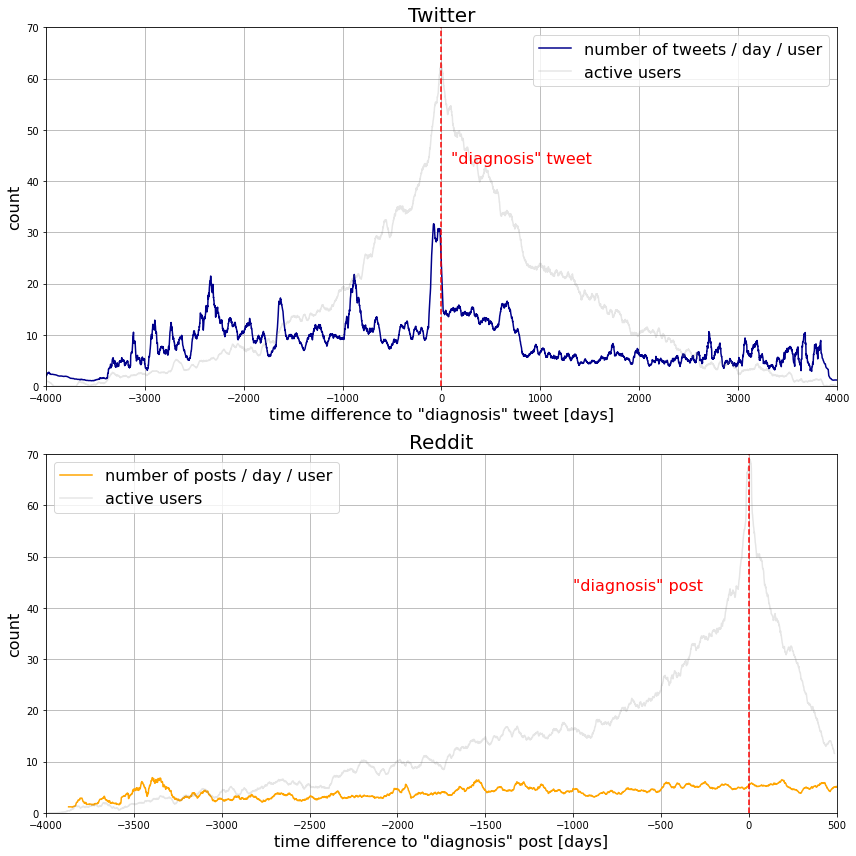

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

ax = axes[0]
ylim = 70
ax.plot(user_averaged_twitter_activity['timediff_to_diagnosis'].rolling(30).mean(),\
        user_averaged_twitter_activity['tweet_count'].rolling(30).mean(),
        label='number of tweets / day / user', color='DarkBlue')

ax.plot(twitter_active_users['timediff_to_diagnosis'].rolling(30).mean(),\
        twitter_active_users['active_users'].rolling(30).mean(), color='grey',
        alpha=0.2, label='active users')

ax.plot([0, 0], [0, ylim], '--', color='r', )
ax.text(100, ax.get_ylim()[1] - 30, '"diagnosis" tweet', color='r', fontsize=16)
ax.set_xlabel('time difference to "diagnosis" tweet [days]', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.grid()
ax.set_xlim(-4000, 4000)
ax.set_ylim(0, ylim)
ax.legend(fontsize=16)
ax.set_title('Twitter', fontsize=20)

ax = axes[1]
ax.plot(user_averaged_reddit_activity['timediff_to_diagnosis'].rolling(30).mean(),\
        user_averaged_reddit_activity['post_count'].rolling(30).mean(),
        label='number of posts / day / user', color='orange')

ax.plot(reddit_active_users['timediff_to_diagnosis'].rolling(30).mean(),\
        reddit_active_users['active_users'].rolling(30).mean(), color='grey',
        alpha=0.2, label='active users')

ax.plot([0, 0], [0, ylim], '--', color='r', )
ax.text(-1000, ax.get_ylim()[1] - 30, '"diagnosis" post', color='r', fontsize=16)
ax.set_xlabel('time difference to "diagnosis" post [days]', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.grid()
ax.set_xlim(-4000, 500)
ax.set_ylim(0, ylim)
ax.legend(fontsize=16)
ax.set_title('Reddit', fontsize=20)
fig.tight_layout()
plt.savefig('../plots/diagnosis_centered_user_activity.pdf')

## Diabetes term & symptom analysis

| term | search terms |
| ---- | ------------ |
| diabetes | diabetes, Diabetes |
| Blood sugar (levels) | blood sugar, sugar levels |
| fasting blood sugar | fasting |
| hyperglycaemia | hyperglycaemia, hyperglycemia |
| insulin (levels) | insulin |
| type 1 / type 2 diabetes | type 1, type 2 |
| Association of Diabetes Care and Education Specialists (ADCES) | ADCES, adces |
| Endocrinologist | Endocrinologist, endocrinologyst |
| risk factors | risk factors |
| milligram / decilitre | mg/dL |
| blood glucose | blood glucose, blood, glucose |

In [25]:
diabetes_terms = [
    'diabetes', 'Diabetes', 'blood sugar', 'sugar levels', 'fasting',
    'hyperglycaemia', 'hyperglycemia', 'insulin', 'Insulin', 'type 1', 'type 2',
    'ADCES', 'adces', 'endocrinologist',  'Endocrinologist', 'risk factor',
    'risk factors', 'mg/dL', 'glucose', 'blood glucose', 'blood']

Diabetes symptoms [from CDC](https://www.cdc.gov/diabetes/basics/symptoms.html):

| symptom | search terms |
| ------- | -------------|
| Urinate (pee) a lot, often at night | urinate, pee |
| Are very thirsty | thirsty, drink a lot |
| Lose weight without trying | lose weight, lost weight, loosing weight |
| Are very hungry | hungry |
| Have blurry vision | blurry vision |
| Have numb or tingling hands or feet | numb, tingling |
| Feel very tired | tired, sleepy, sleep a lot, slept a lot |
| Have very dry skin | dry skin |
| Have sores that heal slowly | sore, sores |
| Have more infections than usual | infection, sick, got a cold, have a cold |

In [26]:
symptoms = ['urinate', 'pee', 'thirsty', 'drink a lot', 'lowe weight',
            'lost weight', 'loosing weight', 'hungry', 'blurry vission', 
            'numb', 'tingling', 'tired', 'sleepy', 'sleep a lot', 'slept a lot',
            'dry skin', 'sore', 'sores', 'infection', 'sick', 'got a cold',
            'have a cold']

In [27]:
def match_symptoms(text):
    matchcount = 0
    for word in symptoms:
        if word in text:
            matchcount += 1
    return matchcount

In [28]:
def match_diabetes_terms(text):
    matchcount = 0
    for word in diabetes_terms:
        if word in text:
            matchcount += 1
    return matchcount

In [29]:
twitter = twitter.dropna(subset=['text'])
reddit = reddit.dropna(subset=['body'])

In [30]:
twitter['symptom_wordcount'] = twitter['text'].apply(match_symptoms)
reddit['symptom_wordcount'] = reddit['body'].apply(match_symptoms)
twitter['diabetes_term_wordcount'] = twitter['text'].apply(match_diabetes_terms)
reddit['diabetes_term_wordcount'] = reddit['body'].apply(match_diabetes_terms)

In [31]:
twitter['symptom_tweet'] = twitter['symptom_wordcount'] > 0
reddit['symptom_post'] = reddit['symptom_wordcount'] > 0
twitter['diabetes_term_tweet'] = twitter['diabetes_term_wordcount'] > 0
reddit['diabetes_term_post'] = reddit['diabetes_term_wordcount'] > 0

In [32]:
reddit['symptom_wordcount'].value_counts()

0     289151
1       8982
2        492
3         63
4          9
10         1
Name: symptom_wordcount, dtype: int64

In [33]:
twitter['symptom_wordcount'].value_counts()

0    1279947
1      18293
2        370
3         14
Name: symptom_wordcount, dtype: int64

In [34]:
reddit['diabetes_term_wordcount'].value_counts()

0    287184
1      7655
2      2253
3       931
4       405
5       168
6        66
7        22
8         8
9         6
Name: diabetes_term_wordcount, dtype: int64

In [35]:
twitter['diabetes_term_wordcount'].value_counts()

0    1174880
1      99591
2      19789
3       3368
4        844
5        127
6         19
7          6
Name: diabetes_term_wordcount, dtype: int64

In [36]:
twitter_symptoms = twitter[['author.username', 'timediff_to_diagnosis', 'symptom_tweet']]\
    .groupby(['author.username', 'timediff_to_diagnosis'])\
    .agg('sum')\
    .rename(columns={'symptom_tweet':'tweet_count'})\
    .reset_index()

twitter_user_averaged_symptoms = twitter_symptoms[['timediff_to_diagnosis', 'tweet_count']]\
    .groupby('timediff_to_diagnosis')\
    .agg(['mean', 'std'])\
    .reset_index()

twitter_diabetes_terms = twitter[['author.username', 'timediff_to_diagnosis', 'diabetes_term_tweet']]\
    .groupby(['author.username', 'timediff_to_diagnosis'])\
    .agg('sum')\
    .rename(columns={'diabetes_term_tweet':'tweet_count'})\
    .reset_index()

twitter_user_averaged_diabetes_terms = twitter_diabetes_terms[['timediff_to_diagnosis', 'tweet_count']]\
    .groupby('timediff_to_diagnosis')\
    .agg('mean')\
    .reset_index()

In [37]:
reddit_symptoms = reddit[['author', 'timediff_to_diagnosis', 'symptom_post']]\
    .groupby(['author', 'timediff_to_diagnosis'])\
    .agg('sum')\
    .rename(columns={'symptom_post':'post_count'})\
    .reset_index()

reddit_user_averaged_symptoms = reddit_symptoms[['timediff_to_diagnosis', 'post_count']]\
    .groupby('timediff_to_diagnosis')\
    .agg('mean')\
    .reset_index()

reddit_diabetes_terms = reddit[['author', 'timediff_to_diagnosis', 'diabetes_term_post']]\
    .groupby(['author', 'timediff_to_diagnosis'])\
    .agg('sum')\
    .rename(columns={'diabetes_term_post':'post_count'})\
    .reset_index()

reddit_user_averaged_diabetes_terms = reddit_diabetes_terms[['timediff_to_diagnosis', 'post_count']]\
    .groupby('timediff_to_diagnosis')\
    .agg('mean')\
    .reset_index()

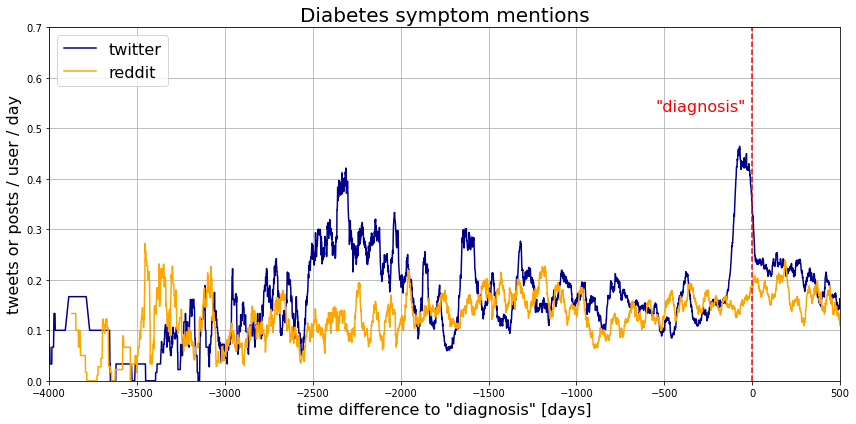

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))

ylim = 0.7
ax.plot(twitter_user_averaged_symptoms['timediff_to_diagnosis'].rolling(30).mean(),\
        twitter_user_averaged_symptoms['tweet_count']['mean'].rolling(30).mean(),
        label='twitter', color='DarkBlue')

ax.plot(reddit_user_averaged_symptoms['timediff_to_diagnosis'].rolling(30).mean(),\
        reddit_user_averaged_symptoms['post_count'].rolling(30).mean(),
        label='reddit', color='orange')

ax.plot([0, 0], [0, ylim], '--', color='r', )
ax.text(-550, ax.get_ylim()[1] - 0.2, '"diagnosis"', color='r', fontsize=16)
ax.set_xlabel('time difference to "diagnosis" [days]', fontsize=16)
ax.set_ylabel('tweets or posts / user / day', fontsize=16)
ax.grid()
ax.set_xlim(-4000, 500)
ax.set_ylim(0, ylim)
ax.legend(fontsize=16)
ax.set_title('Diabetes symptom mentions', fontsize=20)

fig.tight_layout()
plt.savefig('../plots/diagnosis_centered_symptom_mentions.pdf')
plt.savefig('../plots/diagnosis_centered_symptom_mentions.png', dpi=300)

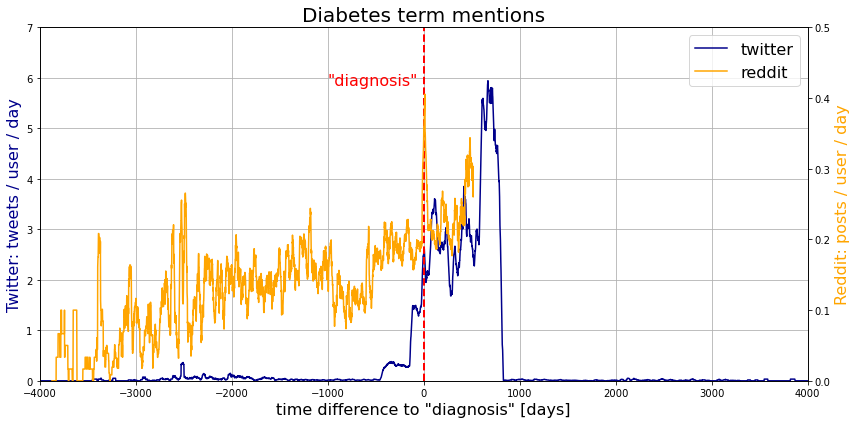

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))

ylim = 7
lns1 = ax.plot(twitter_user_averaged_diabetes_terms['timediff_to_diagnosis'].rolling(30).mean(),\
        twitter_user_averaged_diabetes_terms['tweet_count'].rolling(30).mean(),
        label='twitter', color='DarkBlue')

ax.plot([0, 0], [0, ylim], '--', color='r', linewidth=2)
ax.text(-1000, ax.get_ylim()[1] - 1.5, '"diagnosis"', color='r', fontsize=16)
ax.set_xlabel('time difference to "diagnosis" [days]', fontsize=16)
ax.set_ylabel('Twitter: tweets / user / day', fontsize=16, color='DarkBlue')
ax.grid()
ax.set_xlim(-4000, 4000)
ax.set_ylim(0, ylim)
ax.legend(fontsize=16)
ax.set_title('Diabetes term mentions', fontsize=20)

ax2 = ax.twinx()
ylim = 0.5
lns2 = ax2.plot(reddit_user_averaged_diabetes_terms['timediff_to_diagnosis'].rolling(30).mean(),\
        reddit_user_averaged_diabetes_terms['post_count'].rolling(30).mean(),
        label='reddit', color='orange')
ax2.set_ylabel('Reddit: posts / user / day', fontsize=16, color='orange')
ax2.set_ylim(0, ylim)

# legend
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, fontsize=16)


fig.tight_layout()
plt.savefig('../plots/diagnosis_centered_diabetes_term_mentions.pdf')
plt.savefig('../plots/diagnosis_centered_diabetes_term_mentions.png', dpi=300)